Zu Beginn des Projekts wurden die notwendigen Bibliotheken importiert, um eine reibungslose Bearbeitung und Analyse der Daten zu ermöglichen. Zum Einsatz kamen pandas und numpy für die Datenverarbeitung, matplotlib und seaborn für die grafische Darstellung sowie verschiedene Module aus scikit-learn für die Modellierung und Auswertung. Gleichzeitig wurde mit einer Einstellung das Anzeigen von Warnmeldungen unterdrückt, um die Lesbarkeit des Outputs zu verbessern. Für die Modellbildung und die Bewertung wurden Funktionen wie train_test_split, LabelEncoder, StandardScaler, RandomForestClassifier sowie verschiedene Metriken wie classification_report, confusion_matrix, roc_auc_score, roc_curve und recall_score eingebunden.

Im Anschluss wurde der Datensatz von Invistico Airlines direkt über eine URL eingelesen. Nach dem Laden der Daten erfolgte eine erste Bereinigung, indem alle Zeilen mit fehlenden Werten entfernt wurden. Dies diente dazu, eine möglichst saubere Ausgangsbasis für die weiteren Analysen und Modellierungen zu schaffen. Nach dem Bereinigungsschritt bestand der Datensatz aus 129.880 Einträgen und umfasste 27 Spalten. Zur besseren Übersicht wurden die Namen aller enthaltenen Spalten sowie eine Vorschau der ersten Zeilen des Datensatzes angezeigt.

Da die Zielvariable "satisfaction" ursprünglich als Textwerte vorlag, wurde sie im nächsten Schritt in numerische Werte überführt. Dabei wurde "satisfied" auf 1 und "dissatisfied" auf 0 gemappt. Nach der Umwandlung erfolgte eine Kontrolle der Werte, um sicherzustellen, dass nur noch numerische Einträge vorhanden waren. Anschliessend wurden Zeilen mit fehlenden oder fehlerhaften Angaben in der Zielspalte entfernt, um die Datenqualität weiter zu erhöhen. Nach dieser Bereinigung wurde die Zielvariable für die spätere Modellierung definiert. Zur besseren Einschätzung der Verteilung wurde eine grafische Darstellung erstellt, die zeigte, dass die Klassen "zufrieden" und "unzufrieden" im Datensatz gut vertreten und relativ ausgewogen waren.

Für die Modellierung wurden gezielt sieben relevante Merkmale aus dem Datensatz ausgewählt. Dazu zählten neben demografischen Angaben wie dem Geschlecht und dem Alter auch reisespezifische Informationen wie die Reiseart, die Buchungsklasse, die Flugdistanz sowie Angaben zu Abflug- und Ankunftsverspätungen. Um die kategorischen Variablen wie beispielsweise "Gender", "Type of Travel" und "Class" für das Modell nutzbar zu machen, wurden sie mittels Label-Encoding in numerische Werte umgewandelt. Ausserdem wurden bewusst nur objektive Parameter berücksichtigt, um sicherzustellen, dass reale und nachvollziehbare Zusammenhänge im Vordergrund stehen. Nach dieser Transformation standen sämtliche Eingabemerkmale in numerischer Form zur Verfügung, sodass die Daten für das anschliessende Modelltraining vorbereitet waren. Eine abschliessende Kontrolle bestätigte, dass alle ausgewählten Features korrekt umgewandelt worden waren und die Datenmatrix die erwartete Form aufwies.

Im nächsten Schritt wurden die aufbereiteten Daten in Trainings- und Testdaten unterteilt. Dabei wurden 80 Prozent der Datensätze für das Training des Modells verwendet und 20 Prozent für die spätere Evaluierung zurückgehalten. Insgesamt standen nach der Datenaufbereitung 129.487 Einträge mit sieben ausgewählten Merkmalen zur Verfügung. Um eine einheitliche Skalierung der numerischen Werte sicherzustellen, wurden die Trainings- und Testdaten anschliessend standardisiert. Dies ermöglichte es dem Modell, effizienter zu lernen und vergleichbare Ergebnisse zu liefern. Anstelle eines festen Modells wurde nun ein RandomForestClassifier mit einem Hyperparameter-Tuning (GridSearchCV) eingesetzt. Im Rahmen dieses Tunings wurden verschiedene Kombinationen von Hyperparametern getestet, um das optimale Modell zu finden. Nach dem Training des optimierten Modells auf den Trainingsdaten wurden sowohl die Klassenvorhersagen als auch die vorhergesagten Wahrscheinlichkeiten für die Testdaten berechnet.

Zur Überprüfung der Vorhersagequalität des Modells wurde eine Confusion Matrix erstellt. Diese Matrix zeigte die tatsächlichen und die vorhergesagten Klassenzugehörigkeiten der Testdaten. Das Modell erkannte 8042 unzufriedene Kunden korrekt und ordnete 11879 zufriedene Kunden richtig zu. Auf der anderen Seite wurden 3779 unzufriedene Kunden fälschlicherweise als zufrieden klassifiziert, während 2198 zufriedene Kunden als unzufrieden eingestuft wurden. Insgesamt ergab sich daraus ein stimmiges Bild, das auf eine solide Vorhersageleistung des Modells hinweist, wobei kleinere Ungenauigkeiten insbesondere bei der Erkennung unzufriedener Kunden auftraten.

Ergänzend zur Confusion Matrix wurde die Receiver Operating Characteristic (ROC) Curve berechnet und dargestellt. Diese Kurve visualisiert die Fähigkeit des Modells, zwischen zufriedenen und unzufriedenen Kunden zu unterscheiden, indem sie die wahre positive Rate gegen die falsche positive Rate aufträgt. Das Modell erreichte dabei eine Area Under the Curve (AUC) von 0.83, was auf eine sehr gute Trennschärfe hinweist. Ein AUC-Wert von 1 würde eine perfekte Klassifikation bedeuten, während ein Wert von 0.5 einer rein zufälligen Zuordnung entsprechen würde. Die ermittelte AUC von 0.83 zeigt, dass das Modell eine hohe Genauigkeit bei der Unterscheidung der beiden Klassen aufweist.

Zusätzlich wurde der Recall speziell für unzufriedene Kunden berechnet, um die Fähigkeit des Modells zur Erkennung dieser wichtigen Gruppe genauer zu bewerten. Der Recall-Wert für unzufriedene Kunden lag bei 0.68, was bedeutet, dass 68 Prozent aller tatsächlich unzufriedenen Passagiere vom Modell korrekt identifiziert wurden. Dieser Wert zeigt, dass das Modell eine solide Leistung bei der Erkennung von Unzufriedenheit erzielt, obwohl noch ein gewisser Anteil an unzufriedenen Kunden nicht erkannt wurde. Eine weitere Optimierung des Modells könnte darauf abzielen, die Erkennungsrate in diesem Bereich noch weiter zu verbessern. Zusätzlich wurde die Precision-Recall Curve erstellt, um die Leistung des Modells detaillierter zu untersuchen. Die Kurve zeigt eine hohe Präzision bei niedrigen Recall-Werten und eine deutliche Abnahme der Präzision bei höheren Recall-Werten, was auf eine tendenziell stärkere Fokussierung auf die zufriedenen Kunden hinweist.

Zur detaillierten Bewertung der Modellgüte wurde ein Klassifikationsbericht erstellt, der die wichtigsten Kennzahlen zusammenfasst. Die Precision gibt an, wie zuverlässig die Vorhersagen des Modells sind, also wie viele der als unzufrieden oder zufrieden vorhergesagten Kunden tatsächlich richtig klassifiziert wurden. Für unzufriedene Kunden betrug die Precision 0.79, was bedeutet, dass 79 Prozent der als unzufrieden eingestuften Passagiere tatsächlich unzufrieden waren. Die Recall-Rate misst hingegen, wie gut das Modell alle tatsächlichen Fälle erkannt hat, also wie viele der unzufriedenen Kunden korrekt gefunden wurden. Hier lag der Recall bei 0.68, was bedeutet, dass 68 Prozent aller unzufriedenen Kunden korrekt erkannt wurden.

Für zufriedene Kunden ergab sich eine Precision von 0.76 und ein Recall von 0.84. Daraus ergibt sich der F1-Score, welcher eine harmonische Kombination aus Precision und Recall darstellt und besonders dann eine wichtige Rolle spielt, wenn ein ausgewogenes Verhältnis zwischen beiden Werten angestrebt wird. Der F1-Score lag bei 0.73 für unzufriedene und 0.80 für zufriedene Kunden.

Zusätzlich wurde die Accuracy berechnet, also der Anteil aller korrekten Vorhersagen im Vergleich zur Gesamtzahl der Vorhersagen. Diese betrug 77 Prozent, was bedeutet, dass das Modell insgesamt in 77 Prozent der Fälle die Kundenzufriedenheit richtig vorhergesagt hat. Auch die berechneten Durchschnittswerte, sowohl der ungewichtete Makro-Durchschnitt als auch der gewichtete Durchschnitt unter Berücksichtigung der Klassenverteilung, lagen jeweils bei etwa 77 Prozent.

Diese Ergebnisse bestätigen, dass das Modell eine insgesamt solide Leistung bei der Klassifikation von Kundenzufriedenheit erzielt hat, wobei eine leichte Tendenz zur besseren Erkennung zufriedener Kunden zu beobachten war.

Abschliessend wurde analysiert, welche Merkmale den grössten Einfluss auf die Vorhersage der Kundenzufriedenheit hatten. Dazu wurden die Feature Importances des Random Forest Modells ausgewertet und in einem Balkendiagramm visualisiert. Die Analyse zeigte, dass die Buchungsklasse das wichtigste Merkmal war, gefolgt von Geschlecht und Reiseart. Auch das Alter und die Flugdistanz hatten einen relevanten Einfluss auf die Zufriedenheit. Merkmale wie Abflug- und Ankunftsverspätungen spielten hingegen eine untergeordnete Rolle. Diese Ergebnisse geben wertvolle Hinweise darauf, welche Faktoren bei der Gestaltung von Dienstleistungen besonders berücksichtigt werden sollten, um die Kundenzufriedenheit gezielt zu steigern.

📊 Shape: (129487, 23)
🧾 Spalten:
 ['satisfaction', 'Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class', 'Flight Distance', 'Seat comfort', 'Departure/Arrival time convenient', 'Food and drink', 'Gate location', 'Inflight wifi service', 'Inflight entertainment', 'Online support', 'Ease of Online booking', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']

🔍 Vorschau:


,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Female,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,...,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,Male,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,...,2,3,4,4,4,2,3,2,310,305.0
2,satisfied,Female,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,...,2,2,3,3,4,4,4,2,0,0.0
3,satisfied,Female,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,...,3,1,1,0,1,4,1,3,0,0.0
4,satisfied,Female,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,...,4,2,2,0,2,4,2,5,0,0.0


Vor Verarbeitung: ['satisfied' 'dissatisfied']
Nach Mapping: [1 0]


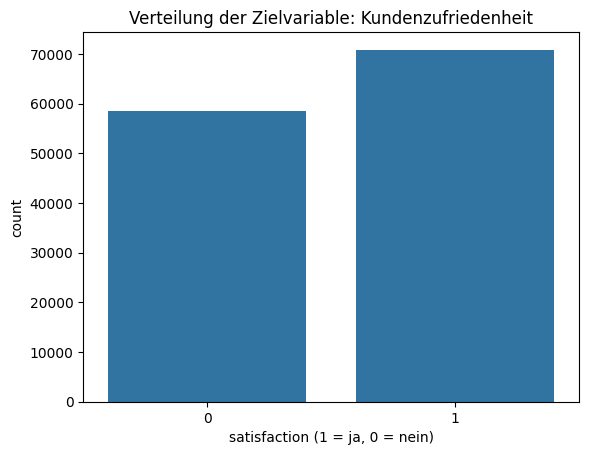

🧠 Input Features: ['Gender', 'Age', 'Type of Travel', 'Class', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
📊 Feature-Matrix Shape: (129487, 7)
Fitting 3 folds for each of 27 candidates, totalling 81 fits


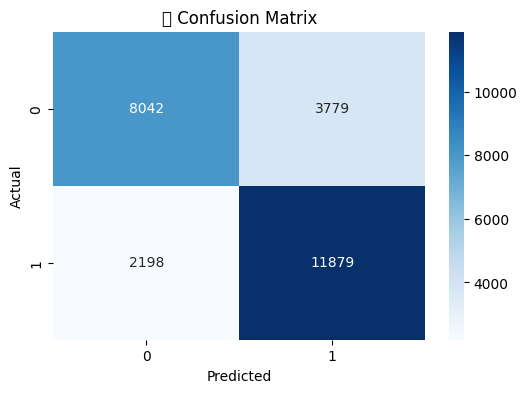

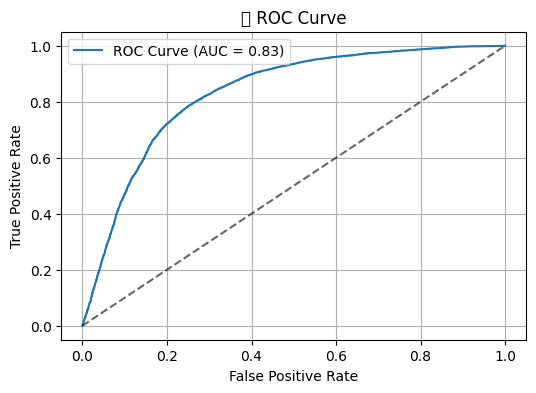

📢 Recall (unzufriedene Kunden erkannt): 0.68


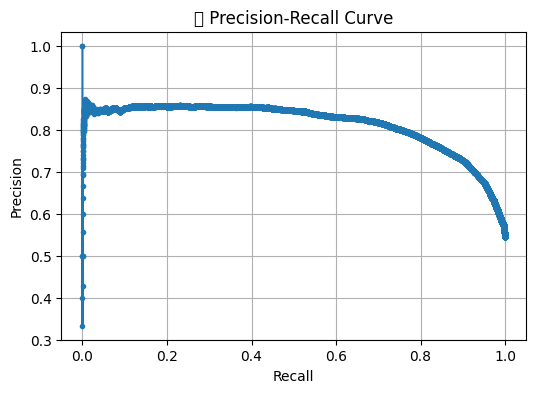


📋 Klassifikationsbericht:

              precision    recall  f1-score   support

           0       0.79      0.68      0.73     11821
           1       0.76      0.84      0.80     14077

    accuracy                           0.77     25898
   macro avg       0.77      0.76      0.76     25898
weighted avg       0.77      0.77      0.77     25898



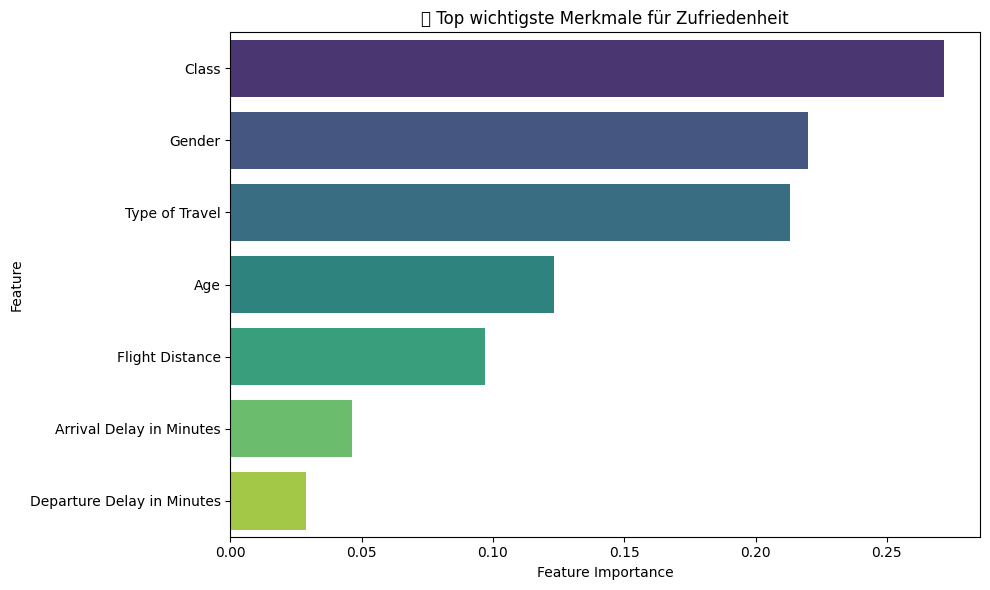

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Sklearn Tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV

# Daten laden
url = "https://raw.githubusercontent.com/DivinitasMaxima/BINA-REPO/refs/heads/main/data/data/Invistico_Airline.csv"
df_Invistico = pd.read_csv(url)
df_Invistico.dropna(inplace=True)

print("📊 Shape:", df_Invistico.shape)
print("🧾 Spalten:\n", df_Invistico.columns.tolist())
print("\n🔍 Vorschau:")
display(df_Invistico.head())

# Vorherige Einträge anschauen
print("Vor Verarbeitung:", df_Invistico['satisfaction'].unique())

# Mapping und Typumwandlung
df_Invistico['satisfaction'] = df_Invistico['satisfaction'].map({'satisfied': 1, 'dissatisfied': 0})
df_Invistico['satisfaction'] = pd.to_numeric(df_Invistico['satisfaction'], errors='coerce')

# Nachherige Einträge anschauen
print("Nach Mapping:", df_Invistico['satisfaction'].unique())

# Fehlende Bewertungen entfernen
df_Invistico = df_Invistico.dropna(subset=['satisfaction'])

# Zielvariable definieren
target = df_Invistico['satisfaction']

# Übersicht der Verteilung
sns.countplot(data=df_Invistico, x='satisfaction')
plt.title("Verteilung der Zielvariable: Kundenzufriedenheit")
plt.xlabel("satisfaction (1 = ja, 0 = nein)")
plt.show()

# 2. Feature-Auswahl

feature_cols = ['Gender', 'Age', 'Type of Travel', 'Class', 'Flight Distance', 
                 'Departure Delay in Minutes', 'Arrival Delay in Minutes'] #'Seat comfort',
features = df_Invistico[feature_cols].copy()

# Kategorische Features labeln
for col in features.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    features[col] = le.fit_transform(features[col].astype(str))

print("🧠 Input Features:", features.columns.tolist())
print("📊 Feature-Matrix Shape:", features.shape)

# 3. Train/Test-Split und Skalierung

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Modelltraining mit Hyperparameter-Tuning

# Parameterbereich definieren
param_grid = {
    'n_estimators': [100, 200, 300],        # Anzahl Bäume
    'max_depth': [10, 20, None],             # Maximale Tiefe der Bäume
    'min_samples_split': [2, 5, 10]          # Mindestanzahl Samples für Split
}

# GridSearchCV-Objekt erstellen
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='accuracy',    # Bewertungsmass
    cv=3,                  # 3-fache Cross-Validation
    verbose=1,             # Fortschrittsanzeige
    n_jobs=-1              # Alle Kerne verwenden
)

# Hyperparameter-Tuning und Training
grid_search.fit(X_train_scaled, y_train)

# Bestes Modell aus Grid Search holen
best_model = grid_search.best_estimator_

# 5. Vorhersagen und Evaluation mit dem besten Modell

y_pred = best_model.predict(X_test_scaled)
y_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# 5.1 Confusion Matrix

plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("🧮 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 5.2 ROC Curve und AUC

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc_score(y_test, y_proba)))
plt.plot([0,1], [0,1], 'k--', alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("🎯 ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# 5.3 Recall für unzufriedene Kunden

recall_unzufrieden = recall_score(y_test, y_pred, pos_label=0)
print(f"📢 Recall (unzufriedene Kunden erkannt): {recall_unzufrieden:.2f}")

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('🎯 Precision-Recall Curve')
plt.grid(True)
plt.show()


# 5.4 Weitere Kennzahlen

print("\n📋 Klassifikationsbericht:\n")
print(classification_report(y_test, y_pred))

# 6. Feature Importances

importances = best_model.feature_importances_
feat_df = pd.DataFrame({'Feature': features.columns, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

# Plot Top Features
plt.figure(figsize=(10,6))
sns.barplot(data=feat_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title("🔥 Top wichtigste Merkmale für Zufriedenheit")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Sklearn Tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, recall_score
from sklearn.model_selection import GridSearchCV

# Daten laden
url = "https://raw.githubusercontent.com/DivinitasMaxima/BINA-REPO/refs/heads/main/data/data/Invistico_Airline.csv"
df_Invistico = pd.read_csv(url)
df_Invistico.dropna(inplace=True)

print("📊 Shape:", df_Invistico.shape)
print("🧾 Spalten:\n", df_Invistico.columns.tolist())
print("\n🔍 Vorschau:")
display(df_Invistico.head())

# Vorherige Einträge anschauen
print("Vor Verarbeitung:", df_Invistico['satisfaction'].unique())

# Mapping und Typumwandlung
df_Invistico['satisfaction'] = df_Invistico['satisfaction'].map({'satisfied': 1, 'dissatisfied': 0})
df_Invistico['satisfaction'] = pd.to_numeric(df_Invistico['satisfaction'], errors='coerce')

# Nachherige Einträge anschauen
print("Nach Mapping:", df_Invistico['satisfaction'].unique())

# Fehlende Bewertungen entfernen
df_Invistico = df_Invistico.dropna(subset=['satisfaction'])

# Zielvariable definieren
target = df_Invistico['satisfaction']

# Übersicht der Verteilung
sns.countplot(data=df_Invistico, x='satisfaction')
plt.title("Verteilung der Zielvariable: Kundenzufriedenheit")
plt.xlabel("satisfaction (1 = ja, 0 = nein)")
plt.show()

# 2. Feature-Auswahl

feature_cols = ['Gender', 'Age', 'Type of Travel', 'Class', 'Flight Distance', 
                'Seat comfort', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
features = df_Invistico[feature_cols].copy()

# Kategorische Features labeln
for col in features.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    features[col] = le.fit_transform(features[col].astype(str))

print("🧠 Input Features:", features.columns.tolist())
print("📊 Feature-Matrix Shape:", features.shape)

# 3. Train/Test-Split und Skalierung

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Modelltraining

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)


# 5. Vorhersagen und Evaluation

y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]  # Wahrscheinlichkeit für Klasse 1 (zufrieden)

# 5.1 Confusion Matrix

plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("🧮 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 5.2 ROC Curve und AUC

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc_score(y_test, y_proba)))
plt.plot([0,1], [0,1], 'k--', alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("🎯 ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# 5.3 Recall für unzufriedene Kunden

recall_unzufrieden = recall_score(y_test, y_pred, pos_label=0)
print(f"📢 Recall (unzufriedene Kunden erkannt): {recall_unzufrieden:.2f}")

# 5.4 Weitere Kennzahlen (optional)

print("\n📋 Klassifikationsbericht:\n")
print(classification_report(y_test, y_pred))

# 6. Feature Importances

importances = model.feature_importances_
feat_df = pd.DataFrame({'Feature': features.columns, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

# Plot Top Features
plt.figure(figsize=(10,6))
sns.barplot(data=feat_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title("🔥 Top wichtigste Merkmale für Zufriedenheit")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
